In [1]:
from PIL import Image 
import multiprocessing
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Grayscale, Resize, ToTensor, Normalize, Compose, Pad
from torch.optim import Adam, lr_scheduler
from tqdm import tqdm
import sys
import os
os.chdir("/kaggle/working")


In [2]:
!git clone --recursive https://github.com/parlance/ctcdecode.git
!cd ctcdecode && pip install .

Cloning into 'ctcdecode'...
remote: Enumerating objects: 1063, done.
remote: Total 1063 (delta 0), reused 0 (delta 0), pack-reused 1063
Receiving objects: 100% (1063/1063), 759.71 KiB | 8.83 MiB/s, done.
Resolving deltas: 100% (513/513), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/kaggle/working/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82        
Cloning into '/kaggle/working/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 13687, done.        
remote: Total 13687 (delta 0), reused 0 (delta 0), pack-reused 13687        
Receiving objects: 100% (13687/13687), 5.46 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (7880/7880), done.
Submodule path 'third_party/ThreadPool': 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Pytorch Dataset class to handle 300k training images

In [9]:
class handWriting_dataset(Dataset):
    
    def __init__(self,split=None,transform=None):
        
        splits = ['train', 'validation', 'test']   

        if not (any(map(lambda x: x != split, splits))):
            raise Exception('Specify which split you want to use train/val/test')
        
        dataset = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_'+split+'_v2.csv')
        #Droping nan rows
        dataset.dropna(axis=0, inplace=True)
        #Droping columns with unreadable tag
        dataset = dataset[dataset['IDENTITY'] != 'UNREADABLE']
        #Converting to uppercase
        dataset['IDENTITY'] = dataset['IDENTITY'].str.upper()
        #reseting indexes
        dataset.reset_index(inplace=True, drop=True)
        
        self.filenames = dataset['FILENAME']
        self.labels = dataset['IDENTITY']
        self.transform = transform
        self.split = split
        
    def __getitem__(self, index):
        
        sample = Image.open('../input/handwriting-recognition/'+ self.split +'_v2/'+ self.split +'/' + self.filenames[index])
       
        if self.transform:
            sample = self.transform(sample)

        return sample, self.labels[index]
        
    def __len__(self):
        return self.labels.shape[0]

## Model

In [10]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut, n_rnn=2):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True, num_layers=n_rnn)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)
        output = output.view(T, b, -1)
        
        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2]
        ps = [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        nm = [64, 64, 128, 128, 256, 256, 512, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False, ):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('dropout{0}'.format(0), nn.Dropout(0.3))  
        convRelu(4, True)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  
        cnn.add_module('dropout{0}'.format(1), nn.Dropout(0.3)) 
        convRelu(5)
        cnn.add_module('dropout{0}'.format(2), nn.Dropout(0.3))  
        convRelu(6, True)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        cnn.add_module('dropout{0}'.format(3), nn.Dropout(0.3))
        convRelu(7, True) 
        cnn.add_module('dropout{0}'.format(4), nn.Dropout(0.3))
        convRelu(8, True)
        cnn.add_module('pooling{0}'.format(4),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        cnn.add_module('dropout{0}'.format(5), nn.Dropout(0.3))
        convRelu(9, True)
         

        self.cnn = cnn
        self.rnn = nn.Sequential(BidirectionalLSTM(512, nh, nclass,n_rnn))
        

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        conv = conv.reshape(conv.size(0), 512, -1)
        
        
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)

        return output

In [11]:
    class TextTransform:

        def __init__(self,alphabet, max_target_len, number_of_timestamps):

            self.letter_to_idx = { alphabet[i] : i for i in range(0, len(alphabet) ) }
            self.idx_to_letter = { i : alphabet[i] for i in range(0, len(alphabet) ) }
            self.max_target_len = 24
            self.num_of_chars = len(alphabet)
            self.num_of_timestamps = 64

        def idx_seq_to_txt(self, pred):
            return [self.idx_to_letter[pred[i]] for i in range(0, len(pred))]

        def txt_to_idx_seq(self, target):
            return [self.letter_to_idx[target[i]] for i in range(0, len(target))]

        def preprocess_batch(self, target_batch):
            preprocessed_batch = []
            target_lengths = []
            for target in target_batch:

                #preprocessed_batch.append(self.pad_idx_seq(self.txt_to_idx_seq(target)))
                target_lengths.append(len(target))
                for letter in target:
                    preprocessed_batch.append(self.letter_to_idx[letter])

            return np.array(preprocessed_batch),np.array(target_lengths)

## Preprocessing & Model setup

In [28]:
alphabet= u"_ABCDEFGHIJKLMNOPQRSTUVWXYZ-'` "
num_of_chars = len(alphabet)
TTransform = TextTransform(alphabet = alphabet, max_target_len = 24,  number_of_timestamps = 64)

#DATASET INIT
IMAGE_SIZE = (64,256)

class Crop:
    def __init__(self, img_size):
        self.img_size = img_size
    
    def __call__(self, sample):
        w, h = sample.size
        sample = sample.crop((0,h - self.img_size[0] ,self.img_size[1], h))
        
        return sample
        

transform = Compose([
                Grayscale(),
                Pad((0,64,256,0), fill=255),
                Crop(IMAGE_SIZE),
                ToTensor(),
                Normalize([0],[255]),
                            ]) 


train_set = handWriting_dataset(split = 'train', transform = transform)
val_set = handWriting_dataset(split = 'validation', transform = transform)

#MODEL INIT
model = CRNN(64, 1, num_of_chars, nh=512, n_rnn=2, leakyRelu=True).to(device)
print(model)
print("Number of parameters = ",sum([param.nelement() for param in model.parameters()]))

model.load_state_dict(torch.load('../input/finalfinal111/MODEL_EPOCH6_0.1054_0.1868'))

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (relu0): LeakyReLU(negative_slope=0.2, inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    (dropout0): Dropout(p=0.3, inplace=False)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): B

<All keys matched successfully>

In [13]:
def train(input_tensor, target_tensor, input_lengths, target_lengths, model, loss_function, optimizer):
        
        model.train()
        model.zero_grad()
        
        model_outputs = model.forward(input_tensor)
        
        log_preds = model_outputs.log_softmax(2)
    
        loss = loss_function(log_preds, target_tensor, input_lengths, target_lengths).to(device)
        
        loss.backward()
        
        optimizer.step()
        
        return loss
    
def val(input_tensor, target_tensor, input_lengths, target_lengths, model, loss_function):
    
        model.eval()
        
        model_outputs = model.forward(input_tensor)
        
        log_preds = model_outputs.log_softmax(2)
        
        loss = loss_function(log_preds, target_tensor, input_lengths, target_lengths).to(device)
        
        return loss
        
        
def trainIters(model, text_transform, train_dataset, val_dataset, num_epochs, learning_rate=0.01, batch_size=64):
    
    num_of_timestamps = 134

    train_loader = DataLoader(dataset = train_set, batch_size = batch_size,shuffle = True,num_workers=1)
    val_loader = DataLoader(dataset = val_set, batch_size = batch_size,shuffle = True,num_workers=1)
    
    loss_function = nn.CTCLoss(blank = 0, reduction='mean', zero_infinity = True).to(device)
    
    
    milestones = [10, 17]
    optimizer = Adam(model.parameters(), lr = learning_rate)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)
    
    
    val_loss_history = []
    train_loss_history = []
    
    for epoch in range(num_epochs):
        
        #TRAIN EPOCH
        t = tqdm(iter(train_loader), total=int(len(train_loader)), leave = False)
        
        train_running_loss = 0.0
        counter = 0
        
        for i_step, data in enumerate(t):
            
            inputs, targets = data

            
            inputs = inputs.to(device)
            input_lengths = torch.full(size=(inputs.size(0),), fill_value=num_of_timestamps, dtype=torch.long).to(device)
                   
            targets, target_lengths  = text_transform.preprocess_batch(targets)
            targets = torch.tensor(targets).to(device)
      
            target_lengths = torch.tensor(target_lengths).to(device)

            loss = train(inputs, targets, input_lengths, target_lengths, model, loss_function, optimizer)
            
            train_running_loss += loss.item()
            counter += 1
            
            t.set_postfix(loss = (train_running_loss/counter))
        
        train_loss = train_running_loss / len(train_loader)
        
        # VAL EPOCH
        t = tqdm(iter(val_loader), total=int(len(val_loader)), leave = False)

        val_running_loss = 0.0
        for i_step, data in enumerate(t):
            
            inputs, targets = data
            
            inputs = inputs.to(device)
            input_lengths = torch.full(size=(inputs.size(0),), fill_value=num_of_timestamps, dtype=torch.long).to(device)
            
            targets, target_lengths  = text_transform.preprocess_batch(targets)
            targets = torch.tensor(targets).to(device)
      
            target_lengths = torch.tensor(target_lengths).to(device)

            loss = val(inputs, targets, input_lengths, target_lengths, model, loss_function)
                
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / len(val_loader)
        
        scheduler.step()
        
        val_loss_history.append(val_loss)
        train_loss_history.append(train_loss)
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)  
        print('Training Loss: {:.4f}'.format(train_loss))
        print('Validation Loss: {:.4f}'.format(val_loss))
        print('-' * 10)  
        sys.stdout.flush()
        
        
        torch.save(model.state_dict(), '../input/hwrfinal/MODEL_EPOCH{}_{:.4f}_{:.4f}'.format(epoch,train_loss,val_loss))
        
    return val_loss_history, train_loss_history

In [ ]:
val_loss_history, train_loss_history = trainIters(model, TTransform, train_set, val_set, 30, learning_rate=0.00001, batch_size=64)

## Evaluation

In [14]:
from ctcdecode import CTCBeamDecoder

decoder = CTCBeamDecoder(
    list(alphabet),
    model_path=None,
    alpha=0,
    beta=0,
    cutoff_top_n=40,
    cutoff_prob=1.0,
    beam_width=50,
    num_processes=4,
    blank_id=0,
    log_probs_input=True
)

In [15]:
model.load_state_dict(torch.load('../input/finalfinal111/MODEL_EPOCH6_0.1054_0.1868'))
model.eval()

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (relu0): LeakyReLU(negative_slope=0.2, inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    (dropout0): Dropout(p=0.3, inplace=False)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): B

In [19]:
def score(model, decoder, test_dataset, batch_size=64, text_transform=None):
    
    num_of_timestamps = 134

    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size,shuffle = True)
    
    t = tqdm(iter(test_loader), total=int(len(test_loader)), leave = False)
    
    counter = 0
    valid = 0
    letter_counter = 0
    valid_letter = 0
        
    for i_step, data in enumerate(t):
            
        inputs, targets = data
       
        inputs = inputs.to(device)
        input_lengths = torch.full(size=(inputs.size(0),), fill_value=num_of_timestamps, dtype=torch.long).to(device)
        
        model.eval()
        
        model_outputs = model.forward(inputs)
        preds = model_outputs.log_softmax(2)
        preds = preds.transpose(0, 1)
        
        beam_results, beam_scores, timesteps, out_lens = decoder.decode(preds)
        output = ''.join(text_transform.idx_seq_to_txt(beam_results[0][0][:out_lens[0][0]].numpy()))
        target = targets[0]
        
        return inputs, targets, beam_results, out_lens
        
        if output == target:
            valid += 1
        
        for i in range(min(len(target), len(output))):
            if output[i] == target[i]:
                valid_letter += 1
        
        letter_counter += len(target)
        counter += 1
        
        t.set_postfix({'accuracy': valid/counter, 'letter_accuracy': valid_letter/letter_counter})
        
    return valid/counter, valid_letter/letter_counter
    

In [17]:
test_set = handWriting_dataset(split = 'test', transform = transform)
acc, letter_acc = score(model, decoder, test_set, batch_size=1, text_transform=TTransform)
print("Accuracy:", acc)
print('Letter_acc:', letter_acc)

Accuracy: 0.8489912567511928
Letter_acc: 0.9465242422448497


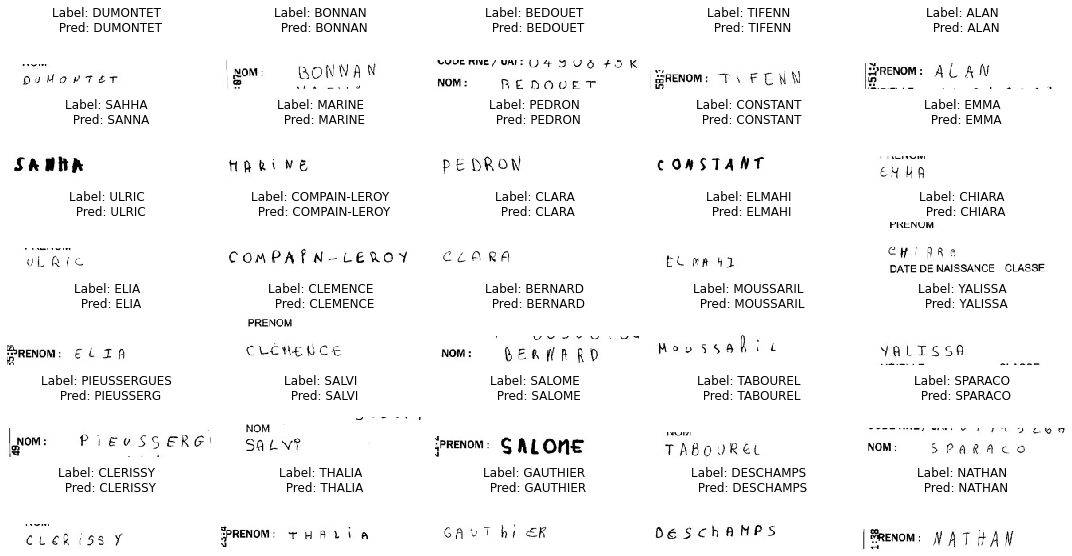

In [30]:
import matplotlib.pyplot as plt

width=2
height=5
rows = 6
cols = 5
axes=[]
fig=plt.figure(figsize=(15,8))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Label: {} \n Pred: {}".format(targets[a], ''.join(TTransform.idx_seq_to_txt(beam_results[a][0][:out_lens[a][0]].numpy()))))
    axes[-1].set_title(subplot_title)  
    plt.imshow(inputs[a].reshape(64,256).cpu(), cmap = 'gray', interpolation='nearest')
    axes[-1].set_axis_off()
fig.tight_layout()    
plt.savefig('example_results')
plt.show()